In [1]:
import pandas
import numpy

In [2]:
df=pandas.read_csv("spam.csv", encoding='latin-1')

In [3]:
df.head(2)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN


In [4]:
df.shape

(5572, 5)

In [5]:
df.isna().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [6]:
df=df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])

In [7]:
df.head(2)

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...


In [8]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
df['v1']=le.fit_transform(df['v1'])

In [9]:
df.head(2)

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...


In [10]:
df.duplicated().sum()

403

In [11]:
df=df.drop_duplicates(keep='first')

<h3>Spam vs Ham texts

In [12]:
spam_vs_ham=df.groupby('v1', as_index=False).count()
spam_vs_ham

,v1,v2
0,0,4516
1,1,653


In [13]:
import matplotlib.pyplot as plt

([<matplotlib.patches.Wedge at 0x2af351126b0>,
 [Text(-1.0144997251399075, 0.4251944351600247, 'ham'),
  Text(1.014499764949479, -0.4251943401757036, 'spam')],
 [Text(-0.5533634864399495, 0.23192423736001344, '87.366998'),
  Text(0.5533635081542612, -0.23192418555038377, '12.633005')])

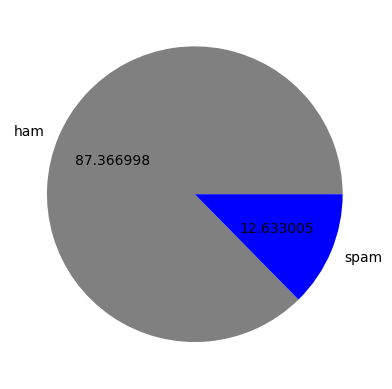

In [14]:
plt.pie(spam_vs_ham['v2'], labels=['ham', 'spam'], autopct="%f", colors=['grey', 'blue'])

In [15]:
import nltk

In [16]:
!pip install nltk

Defaulting to user installation because normal site-packages is not writeable


In [17]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\WINDOWS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [18]:
df['num_char']=df['v2'].apply(len)
df['num_words']=df['v2'].apply(lambda x: len(nltk.word_tokenize(x)))
df['num_sent']=df['v2'].apply(lambda x: len(nltk.sent_tokenize(x)))

In [19]:
df.head(2)

,v1,v2,num_char,num_words,num_sent
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2


<h3>Finding Correlation between variou features of text

In [20]:
import seaborn as sns

C:\Users\WINDOWS\AppData\Local\Temp\ipykernel_19608\621126171.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True)


<AxesSubplot: >

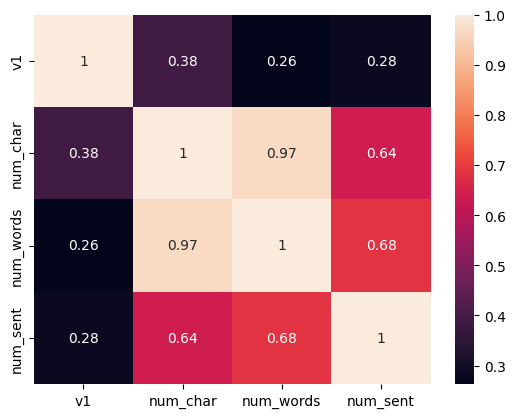

In [21]:
sns.heatmap(df.corr(), annot=True)

<h3>Filtering the text

In [22]:
from nltk.corpus import stopwords
import string
from nltk.stem.porter import PorterStemmer
ps=PorterStemmer()

In [23]:
def filter_text(text):
   
    text=text.lower()

    text=nltk.word_tokenize(text)

    result=[]
    for char in text:
        if char.isalnum():
            result.append(char)
    
    text=result[:]
    result.clear()

    for word in text:
        if word not in stopwords.words('english') and word not in string.punctuation:
            result.append(word)

    text=result[:]
    result.clear()

    for item in text:
        result.append(ps.stem(item))

    return " ".join(result)

In [24]:
filter_text("hey how are you, do you wanna join for dinner?")

'hey wan na join dinner'

In [25]:
df['filtered_text']=df['v2'].apply(filter_text)

In [26]:
df.head(2)

,v1,v2,num_char,num_words,num_sent,filtered_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni


<h3>Developing the model

<h5>Vectorizing the text

In [27]:
from sklearn.feature_extraction.text import CountVectorizer
tfidf=CountVectorizer()

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
X = tfidf.fit_transform(df['filtered_text']).toarray()
y=df['v1'].values

In [30]:
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2, random_state=2)

In [31]:
from sklearn.naive_bayes import MultinomialNB
mnb=MultinomialNB()
mnb.fit(X_train,y_train)

MultinomialNB()

In [32]:
y_pred=mnb.predict(X_test)

In [33]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [34]:
accuracy_score(y_test, y_pred)

0.9642166344294004

In [35]:
confusion_matrix(y_test, y_pred)

array([[871,  25],
       [ 12, 126]], dtype=int64)

In [36]:
import pickle
pickle.dump(tfidf, open('vectorizer.pkl', 'wb'))
pickle.dump(mnb, open('mnb_model.pkl', 'wb'))